# **VisionGPT-2 Image Captioning Model**
---

- *almost* built from scratch.
- pretrained weights loading via HF & timm
- dataset preparation from scratch as well.

# Imports
---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timm import create_model, list_models
from types import SimpleNamespace
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import gc
import json

c:\Users\neody\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\neody\AppData\Roaming\Python\Python38\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
%env TOKENIZERS_PARALLELISM = false

# Dataset
---
- the dataset we're using is `COCO 2017`, it has about 500k samples, we will only use 150k samples. 
- augmentations: PIL + albumentations. Fun fact: albumentations is a LOT faster than torchvision
- mean and std for ViT models is `[0.5,0.5,0.5]` unlike the standard ImageNet mean and std.

In [2]:
sample_tfms = [
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])

In [3]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token

c:\Users\neody\AppData\Local\Programs\Python\Python38\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\neody\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


'<|endoftext|>'

In [4]:
tokenizer.encode_plus('hello! this is a caption')

{'input_ids': [31373, 0, 428, 318, 257, 8305], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [5]:
class Dataset:
    def __init__(self, df, tfms):
        self.df = df
        self.tfms = tfms
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        image = sample['image']
        caption = sample['caption']
        image = Image.open(image).convert('RGB')
        image = np.array(image)
        augs = self.tfms(image=image)
        image = augs['image']
        caption = f"{caption}<|endoftext|>"
        input_ids = tokenizer(
            caption,
            truncation=True)['input_ids']
        labels = input_ids.copy()
        labels[:-1] = input_ids[1:]
        return image,input_ids,labels

In [15]:
# COCO 2017
base_path = Path('/kaggle/input/coco-2017-dataset/coco2017')
annot = base_path / 'annotations' / 'captions_train2017.json'
with open(annot, 'r') as f:
    data = json.load(f)
    data = data['annotations']

samples = []

for sample in data:
    im = '%012d.jpg' % sample['image_id']
    samples.append([im, sample['caption']])

df = pd.DataFrame(samples, columns=['image', 'caption'])
df['image'] = df['image'].apply(
    lambda x: base_path / 'train2017' / x
)
df = df.sample(150_000)
df = df.reset_index(drop=True)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '\\kaggle\\input\\coco-2017-dataset\\coco2017\\annotations\\captions_train2017.json'

#### some samples from the dataset

In [ ]:
sampled_df = df.sample(n=20)
fig, axs = plt.subplots(10, 2, figsize=(20, 30))

for i, row in enumerate(sampled_df.iterrows()):
    ax = axs[i // 2, i % 2]
    image_path = row[1]['image']
    caption = row[1]['caption']
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(caption)

plt.tight_layout()
plt.show()

#### you can also choose to use Flickr30k which has ~160k samples

In [ ]:
# flickr30k
"""
base_path = Path('/kaggle/input/flickr30k/flickr30k_images')
df = pd.read_csv('/kaggle/input/flickr30k/captions.txt',delimiter=',')
df.rename({'image_name':'image','comment': 'caption'},inplace=True,axis=1)
df['image'] = df['image'].map(lambda x:base_path / x.strip())
df['caption'] = df['caption'].map(lambda x:x.strip().lower())
df.head()
"""

In [ ]:
train_df, val_df = train_test_split(df,test_size=0.1)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
print(len(train_df),len(val_df))

In [16]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)

NameError: name 'train_df' is not defined

In [27]:
train_ds = Dataset([0], train_tfms)
val_ds = Dataset([0], valid_tfms)

## Custom collate function
---

- allows for dynamic padding so the model doesn't have to process `max_len` sequences which would be just filled with pad tokens
- instead, every batch is padded according to the longest sequence in the batch

In [6]:
def collate_fn(batch):
    image = [i[0] for i in batch]
    input_ids = [i[1] for i in batch]
    labels = [i[2] for i in batch]
    image = torch.stack(image,dim=0)
    input_ids = tokenizer.pad(
        {'input_ids':input_ids},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    labels = tokenizer.pad(
        {'input_ids':labels},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    mask = (input_ids!=tokenizer.pad_token_id).long()
    labels[mask==0]=-100
    return image, input_ids, labels

## How the data looks:
---
- every caption is a sequence of tokens, and as it is causal language modeling where the model predicts the next token, the labels are right shifted by 1 position.
- every caption ends with the end of sentence token: eos_token (50256 : <|endoftext|>)
- in GPT models, the pad tokens are same as the eos tokens, hence we also mask the pad tokens in the labels with -100 which are ignored by cross-entropy loss' default behaviour -- check `collate_fn` to see how I masked them. 

In [ ]:
dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=2,collate_fn=collate_fn)
_,c,l = next(iter(dl))
print(c[0])
print(l[0])

# Model
---

- GPT2 on its own is a decoder-only model. So it understands only textual context. To create a model which also understands image context and applies it to the text, we use cross-attention.
- Cross Attention: It is the second attention layer of the decoder block as per the [classic transformer encoder-decoder model](https://www.arxiv-vanity.com/papers/1706.03762/)
- The query in cross-attention is the output of the previous causal attention layer in the decoder block. The key and value are the outputs of the corresponding encoder block i.e. the image context.
- Since GPT2 doesn't have a cross-attention layer, I coded it as `GPT2CrossAttention` and made it a part of the usual decoder `GPT2Block`.
- The encoder I used was ViT-base with patch_size=16 grabbed from `timm`.
- ViT and GPT2 are extremely compatible with each other. They have the same amount of depth i.e. encoder, decoder blocks respectively. They have the same hidden size of 768 as well. So I didn't have to pool the encoder outputs to match the decoder hidden size. Less parameters yay!
- GPT2 code I wrote was ofc based on what I learnt from [NanoGPT](https://github.com/karpathy/nanoGPT)

### This is somewhat how the architecture looks now.
![](https://i.imgur.com/fk68DMo.jpg)
*I drew this :)*

## Causal Attention Block
---

In [7]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5
        
        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        
    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

## Cross Attention Block
---
- Notice how I initialized the parameters with mean=0. and std=0.02. This is an OpenAI trick they used while training GPT2 as well.

In [8]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        
    def forward(self, q,k,v):
        b,t,c = q.shape
        
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        
        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

## Feed Forward Block
---

In [9]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout
        
        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

## Decoder Block
---
- with added cross-attention and pre-normalization

In [10]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)
        
    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

## The main model
---
- creating ViT model via timm
- added embedding code and right forward pass for the ViT model as per [their code.](https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py)
- each encoder output is passed to the decoder input and to the next encoder input as well.
- the final decoder outputs are passed through a head block to generate logits as per the vocab size.
- loss is calculated using cross-entropy if labels are present else, logits for the final token in the sequence are returned for generation.
- `pretrained_layers_trainable`: freezes/unfreezes ViT and GPT2 pretrained layers
- `unfreeze_gpt_layers`: unfreezes GPT2 layers only
- `from_pretrained`: loads GPT2 weights via huggingface gpt2
- `generate`: generates caption, sampling via `torch.multinomial` or deterministic via `argmax` with `temperature` control.

In [11]:
class VisionGPT2Model(nn.Module):
    def __init__(self,config):
        super().__init__()
        
        self.config = config
        
        vit = create_model('vit_base_patch16_224',pretrained=True,num_classes=0)
        self.patch_embed = vit.patch_embed
        num_patches = self.patch_embed.num_patches
        
        self.cls_token = vit.cls_token
        embed_len = num_patches + vit.num_prefix_tokens
        self.pos_embed = vit.pos_embed
        self.pos_drop = nn.Dropout(p=0.)
        
        self.blocks = nn.ModuleList([vit.blocks[i] for i in range(config.depth)])
        
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size,config.embed_dim),
            wpe = nn.Embedding(config.seq_len,config.embed_dim),
            drop = nn.Dropout(config.emb_dropout),
            h = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)]),
            ln_f = nn.LayerNorm(config.embed_dim)
        ))
        self.lm_head = nn.Linear(config.embed_dim,config.vocab_size,bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        
    def _pos_embed(self,x):
        pos_embed = self.pos_embed
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = x + pos_embed
        return self.pos_drop(x)
    
    def pretrained_layers_trainable(self,trainable=False):
        layers = [
            self.cls_token, self.patch_embed, self.pos_embed, self.blocks,
            self.transformer.wte, self.transformer.wpe,
            self.transformer.ln_f, self.lm_head
        ]
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        for l in gpt_layers:
            layers.extend(l)
        
        for layer in layers:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = trainable
            else:
                layer.requires_grad = trainable
                
        total_frozen_params = sum([p.numel() for p in self.parameters() if not p.requires_grad])
        print(f'{total_frozen_params=}')
        
    def unfreeze_gpt_layers(self,):
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        flatten = []
        for l in gpt_layers:
            flatten.extend(l)
            
        for layer in flatten:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = True
            else:
                layer.requires_grad = True
        
    @classmethod    
    def from_pretrained(self,config):
        model = VisionGPT2Model(config)
        sd = model.state_dict()
        keys = sd.keys()
        ignore_matches = ['blocks.','cross_attn.','ln_3','cls_token','pos_embed','patch_embed.','.attn.mask']
        vit_keys = [key for key in keys if any(match in key for match in ignore_matches)]
        gpt_keys = [key for key in keys if key not in vit_keys]
        
        gpt2_small = GPT2LMHeadModel.from_pretrained('gpt2')
        sd_hf = gpt2_small.state_dict()
        hf_keys = sd_hf.keys()
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.masked_bias')]
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        
        for k in hf_keys:
            if any(match in k for match in ignore_matches):
                continue
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
            
        model.load_state_dict(sd)
        
        return model
    
    def forward(self,image,input_ids,labels=None):
        
        image = self.patch_embed(image)
        image = self._pos_embed(image)
        
        token_embeddings = self.transformer.wte(input_ids) # batch x seq_len
        pos_embs = torch.arange(0,input_ids.size(1)).to(input_ids.device)
        positional_embeddings = self.transformer.wpe(pos_embs)
        input_ids = self.transformer.drop(token_embeddings+positional_embeddings)
        
        for i in range(self.config.depth):
            image = self.blocks[i](image)
            input_ids = self.transformer.h[i](input_ids, image)
        
        input_ids = self.transformer.ln_f(input_ids)
        
        if labels is not None:
            lm_logits = self.lm_head(input_ids)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss
        
        lm_logits = self.lm_head(input_ids[:,[-1],:])
        return lm_logits
    
    def generate(self,image,sequence,max_tokens=50,temperature=1.0,deterministic=False):
        for _ in range(max_tokens):
            out = self(image,sequence)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            sequence = torch.cat([sequence,next_token],dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break
            
        return sequence.cpu().flatten()

# Training
---
- the pretrained layers are initially frozen as I need to train the cross attention layers first
- in the following epochs, GPT2 is unfreezed and trained, in the final few epochs, the ViT is unfreezed as well.
- optimizer: Adam
- scheduler: OneCycleLR
- mixed-precision fp16 training with autocast and grad-scaler in torch
- metrics: cross-entropy loss and perplexity = e^loss, both lower the better
- best model is saved based on validation perplexity and the same is loaded while generating captions.

### Generation

- GPT2 generally requires context before generating anything, since for image captioning we can't really provide an initial context except the image itself, the initial context we provide to GPT is just `[50256]` i.e `<|endoftext|>` which is also the beginning of sentence token in GPT. For other models such as OPT it is `</s>`. This one token acts as the initial context.

In [12]:
class Trainer:
    def __init__(self,model_config,train_config, dls):
        
        self.train_config = train_config
        self.model_config = model_config
        self.device = self.train_config.device
        
        self.model = VisionGPT2Model.from_pretrained(model_config).to(self.device)
        self.model.pretrained_layers_trainable(trainable=False)
        
        print(f'trainable parameters: {sum([p.numel() for p in self.model.parameters() if p.requires_grad])}')
        
        self.tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token
        
        self.scaler = GradScaler()
        
        self.train_dl, self.val_dl = dls
        
        total_steps = len(self.train_dl)
        
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.train_config.lr / 25.)
        self.sched = torch.optim.lr_scheduler.OneCycleLR(
            self.optim,
            max_lr=self.train_config.lr,
            epochs=self.train_config.epochs,
            steps_per_epoch=total_steps
        )
        
#         self.sched = get_linear_schedule_with_warmup(self.optim,num_warmup_steps=0,num_training_steps=total_steps)
        
        self.metrics = pd.DataFrame()
        self.metrics[['train_loss','train_perplexity','val_loss','val_perplexity']] = None
        
        self.gen_tfms = A.Compose([
            A.Resize(224,224),
            A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
            ToTensorV2()
        ])
            
        
    def save_model(self,):
        self.train_config.model_path.mkdir(exist_ok=True)
        sd = self.model.state_dict()
        torch.save(sd,self.train_config.model_path/'captioner.pt')
        
        
    def load_best_model(self,):
        sd = torch.load(self.train_config.model_path/'captioner.pt')
        self.model.load_state_dict(sd)
    
    
    def train_one_epoch(self,epoch):
        
        prog = tqdm(self.train_dl,total=len(self.train_dl))
        
        running_loss = 0.
        
        for image, input_ids, labels in prog:
            
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)
                
                loss = self.model(image,input_ids,labels)
                
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optim)
                self.scaler.update()
                self.sched.step()
                self.optim.zero_grad(set_to_none=True)
                
                running_loss += loss.item()
                
                prog.set_description(f'train loss: {loss.item():.3f}')
                
            del image, input_ids, labels, loss
            
        train_loss = running_loss / len(self.train_dl)
        train_pxp = np.exp(train_loss)
        
        self.metrics.loc[epoch,['train_loss','train_perplexity']] = (train_loss,train_pxp)
        
        
    @torch.no_grad()
    def valid_one_epoch(self,epoch):
        
        prog = tqdm(self.val_dl,total=len(self.val_dl))
        
        running_loss = 0.
        
        for image, input_ids, labels in prog:
            
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)
                
                loss = self.model(image,input_ids,labels)
                running_loss += loss.item()
                
                prog.set_description(f'valid loss: {loss.item():.3f}')
                
            del image, input_ids, labels, loss
            
        val_loss = running_loss / len(self.val_dl)
        val_pxp = np.exp(val_loss)
        
        self.metrics.loc[epoch,['val_loss','val_perplexity']] = (val_loss,val_pxp)
        
        return val_pxp
        
        
    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()
       
    
    def fit(self,):
        
        best_pxp = 1e9
        best_epoch = -1
        prog = tqdm(range(self.train_config.epochs))
        
        for epoch in prog:
            
            if epoch == self.train_config.freeze_epochs_gpt:
                self.model.unfreeze_gpt_layers()
                print('unfreezing GPT2 entirely...')
                
            if epoch == self.train_config.freeze_epochs_all:
                self.model.pretrained_layers_trainable(trainable=True)
            
            self.model.train()
            prog.set_description('training')
            self.train_one_epoch(epoch)
            self.clean()
            
            self.model.eval()
            prog.set_description('validating')
            pxp = self.valid_one_epoch(epoch)
            self.clean()
            
            print(self.metrics.tail(1))
            
            if pxp < best_pxp:
                best_pxp = pxp
                best_epoch = epoch
                print('saving best model...')
                self.save_model()
                
        return {
            'best_perplexity': best_pxp,
            'best_epoch': best_epoch
        }
           
        
    @torch.no_grad()
    def generate_caption(self,image,max_tokens=50,temperature=1.0,deterministic=False):
        
        self.model.eval()
        
        image = Image.open(image).convert('RGB')
        image = np.array(image)
        image = self.gen_tfms(image=image)['image']
        image = image.unsqueeze(0).to(self.device)
        sequence = torch.ones(1,1).to(device=self.device).long() * self.tokenizer.bos_token_id
        
        caption = self.model.generate(
            image,
            sequence,
            max_tokens=max_tokens,
            temperature=temperature,
            deterministic=deterministic
        )
        caption = self.tokenizer.decode(caption.numpy(),skip_special_tokens=True)
        
        return caption

In [13]:
model_config = SimpleNamespace(
    vocab_size = 50_257,
    embed_dim = 768,
    num_heads = 12,
    seq_len = 1024,
    depth = 12,
    attention_dropout = 0.1,
    residual_dropout = 0.1,
    mlp_ratio = 4,
    mlp_dropout = 0.1,
    emb_dropout = 0.1,
)
train_config = SimpleNamespace(
    epochs = 5,
    freeze_epochs_gpt = 1,
    freeze_epochs_all = 2,
    lr = 1e-4,
    device = 'cuda',
    model_path = Path('captioner'),
    batch_size = 32
)

In [22]:
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=train_config.batch_size,shuffle=True,pin_memory=True,num_workers=2,persistent_workers=True,collate_fn=collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds,batch_size=train_config.batch_size,shuffle=False,pin_memory=True,num_workers=2,persistent_workers=True,collate_fn=collate_fn)

In [23]:
trainer = Trainer(model_config,train_config,(train_dl,val_dl))

total_frozen_params=210236928
trainable parameters: 28366848


In [ ]:
trainer.fit()

# Results
---

In [ ]:
trainer.metrics

In [ ]:
plt.plot(trainer.metrics['train_loss'],color='red',label='train loss')
plt.plot(trainer.metrics['val_loss'],color='orange',label='valid loss')
plt.title('loss, lower=better')
plt.legend()
plt.show()

In [ ]:
plt.plot(trainer.metrics['train_perplexity'],color='blue',label='train perplexity')
plt.plot(trainer.metrics['val_perplexity'],color='lightblue',label='valid perplexity')
plt.title('perplexity, lower=better')
plt.legend()
plt.show()

# Predictions
---

In [25]:
trainer.load_best_model()

In [ ]:
for i in range(50):
    det = False
    test = val_df.sample(n=1).values[0]
    test_img, test_caption = test[0],test[1]
    plt.imshow(Image.open(test_img).convert('RGB'))
    t = np.random.uniform(0.5,1.5)
    if i > 40:
        det = True
    gen_caption = trainer.generate_caption(test_img,temperature=t,deterministic=det)
    plt.title(f"actual: {test_caption}\nmodel: {gen_caption}\ntemp: {t} deterministic generation: {det}")
    plt.axis('off')
    plt.show()

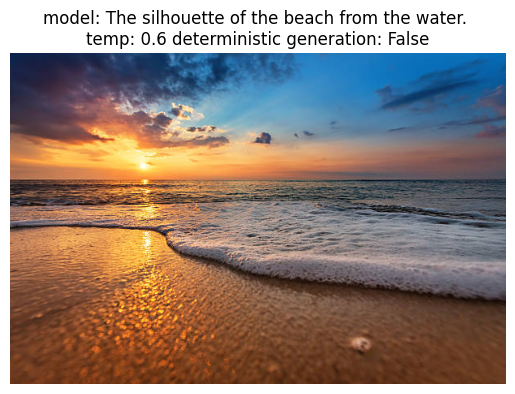

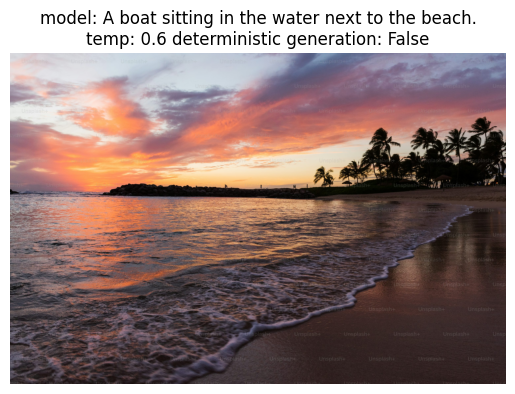

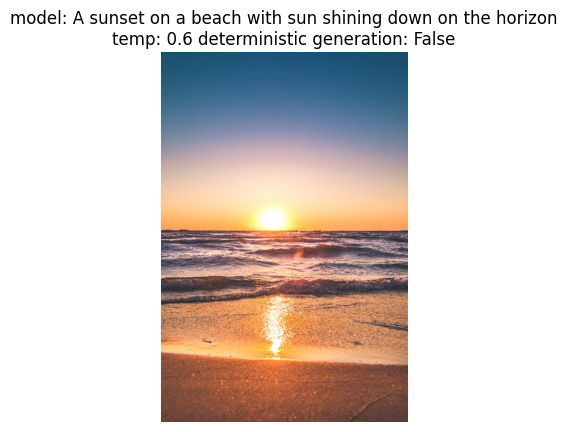

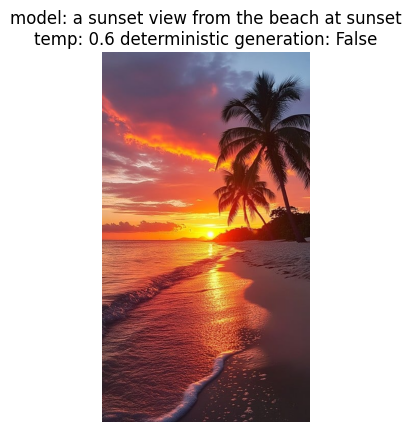

In [36]:
testSet = ["testdata\\im1.jpg", "testdata\\im2.jpg", "testdata\\im3.jpg", "testdata\\im4.jpg"]
for p in testSet:
    det = False
    plt.imshow(Image.open(p).convert('RGB'))
    t = 0.6
    gen_caption = trainer.generate_caption(p, max_tokens=100, temperature=t,deterministic=det)
    plt.title(f"model: {gen_caption}\ntemp: {t} deterministic generation: {det}")
    plt.axis('off')
    plt.show()

# Conclusion
---

- Dataset options which are a good start: Flickr8k, Flickr30k, MS-COCO
- The generations are good not great, can definitely train for a lot longer for better results
- Additional decoding strategies like beam, contrastive could've been implemented
- All of this can be done using HuggingFace `VisionEncoderDecoderModel` and their `Seq2SeqTrainer`, here's a [tutorial](https://ankur3107.github.io/blogs/the-illustrated-image-captioning-using-transformers/)
- I wanted to implement this from scratch since I like exploring model architectures! Check out my [Github](https://github.com/shreydan) for more stuff like this.
- Follow me on [Kaggle](https://kaggle.com/shreydan) if you haven't already!
- Upvote (it really helps), comment your thoughts and lemme know what else I could've done to improve or bring any errors I made to my attention (pun intended).
- See you around!

> Attention is all you need.
---
Psalm 32:8